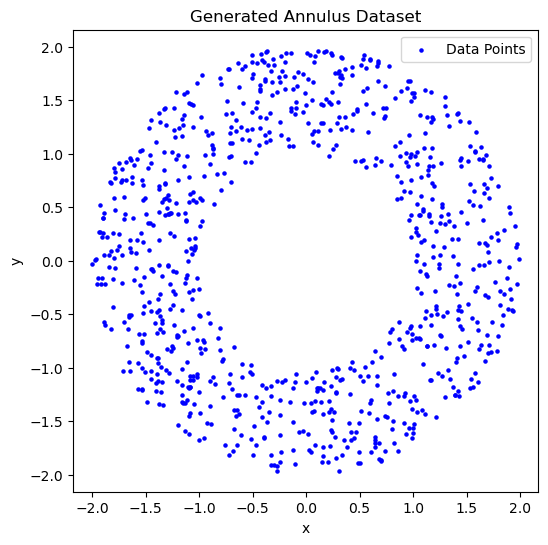

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

R_INNER = 1.0
R_OUTER = 2.0
N_SAMPLES = 900
N_COMPONENTS = 30
MAX_ITERATIONS = 300
PLOT_ITERATIONS = [0, 25, 50, 75, 275, 300]

r_min_sq = R_INNER**2
r_max_sq = R_OUTER**2
r_sq = np.random.uniform(r_min_sq, r_max_sq, N_SAMPLES)
r = np.sqrt(r_sq)
theta = np.random.uniform(0, 2 * np.pi, N_SAMPLES)

X = np.stack([r * np.cos(theta), r * np.sin(theta)], axis=1)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=5, color='blue', label='Data Points')
plt.title('Generated Annulus Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.legend()
plt.show()

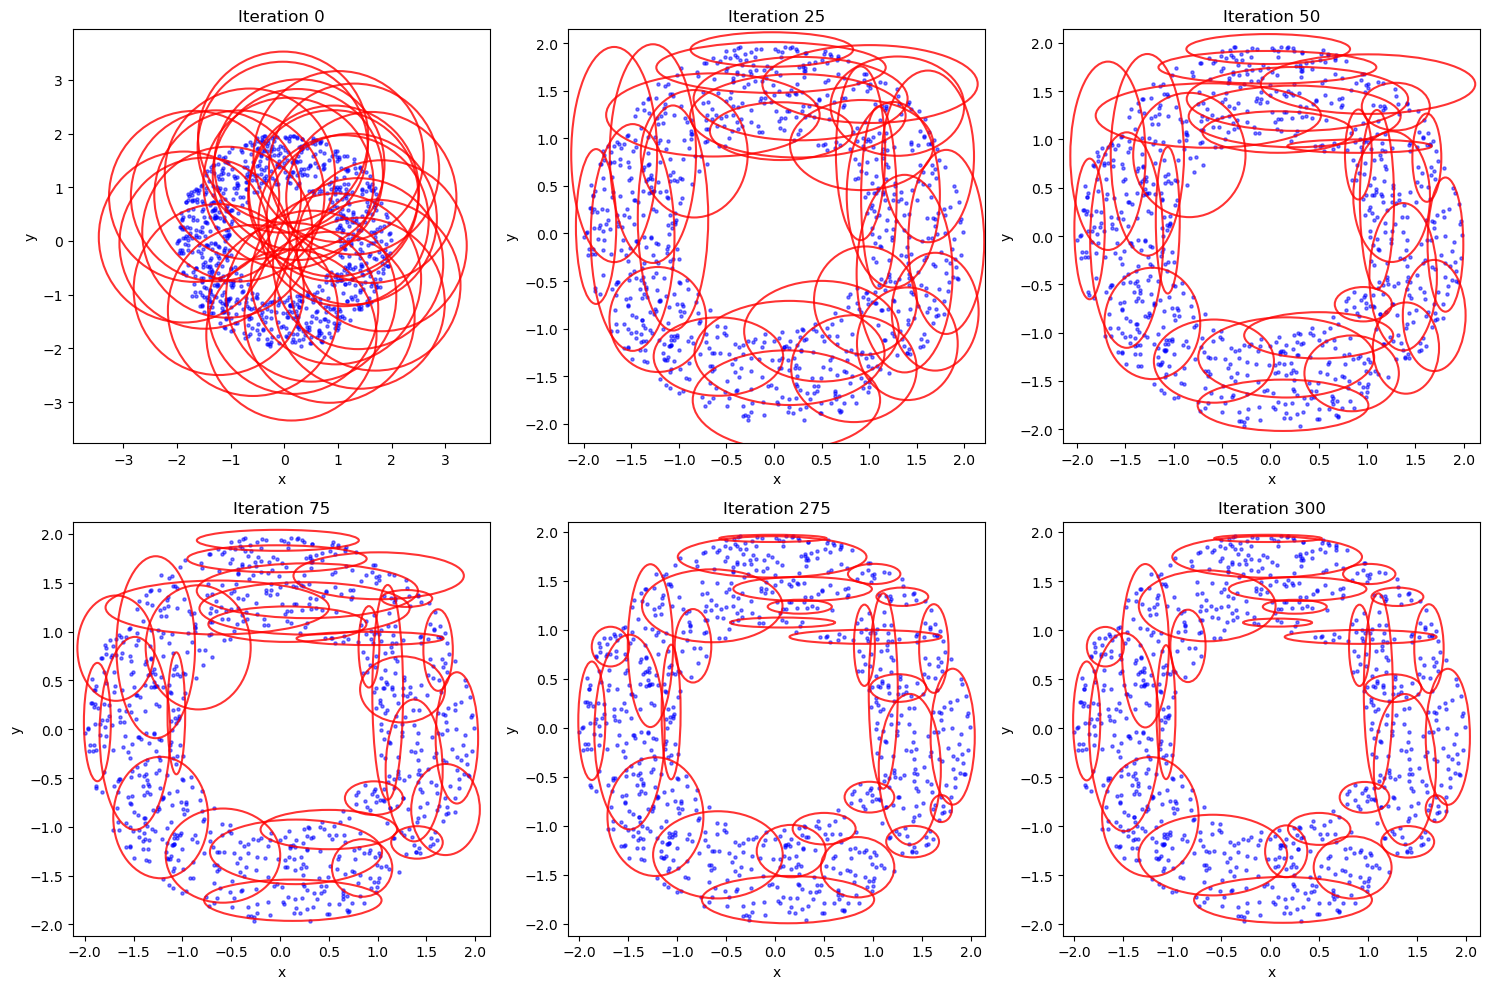

In [27]:
def plot_gmm(X, means, covariances, iteration_num, ax):
    ax.scatter(X[:, 0], X[:, 1], s=5, color='blue', alpha=0.5)
    for i in range(len(means)):
        eig_vals, eig_vecs = np.linalg.eigh(covariances[i])
        unit_eig_vec = eig_vecs[0]
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        angle = np.degrees(angle)
        width, height = 2 * 2 * np.sqrt(eig_vals)
        ell = Ellipse(xy=means[i], width=width, height=height, angle=angle, 
                      edgecolor='red', fc='None', lw=1.5, alpha=0.8)
        ax.add_patch(ell)
    ax.set_title(f'Iteration {iteration_num}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')

random_idx = np.random.choice(N_SAMPLES, N_COMPONENTS, replace=False)
means = X[random_idx].copy()
weights = np.ones(N_COMPONENTS) / N_COMPONENTS
data_var = np.var(X, axis=0)
covariances = np.array([np.diag(data_var) * 0.5 for _ in range(N_COMPONENTS)])

log_likelihoods = []
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes_flat = axes.flatten()
plot_idx = 0

if 0 in PLOT_ITERATIONS:
    plot_gmm(X, means, covariances, 0, axes_flat[plot_idx])
    plot_idx += 1

for iteration in range(1, MAX_ITERATIONS + 1):
    weighted_pdfs = np.zeros((N_SAMPLES, N_COMPONENTS))
    for k in range(N_COMPONENTS):
        try:
            weighted_pdfs[:, k] = weights[k] * multivariate_normal.pdf(
                X, mean=means[k], cov=covariances[k], allow_singular=True
            )
        except np.linalg.LinAlgError:
            weighted_pdfs[:, k] = 1e-10

    sum_weighted = np.sum(weighted_pdfs, axis=1, keepdims=True)
    sum_weighted[sum_weighted == 0] = 1e-10
    log_lik = np.sum(np.log(sum_weighted))
    log_likelihoods.append(log_lik)

    responsibilities = weighted_pdfs / sum_weighted

    N_k = np.sum(responsibilities, axis=0)
    weights = N_k / N_SAMPLES
    
    for k in range(N_COMPONENTS):
        resp_k = responsibilities[:, k].reshape(-1, 1)
        means[k] = np.sum(resp_k * X, axis=0) / (N_k[k] + 1e-10)
        
        diff = X - means[k]
        cov_k = np.dot((resp_k * diff).T, diff) / (N_k[k] + 1e-10)
        covariances[k] = np.diag(np.diag(cov_k))
        np.fill_diagonal(covariances[k], np.maximum(np.diag(covariances[k]), 1e-6))

    if iteration in PLOT_ITERATIONS:
        if plot_idx < len(axes_flat):
            plot_gmm(X, means, covariances, iteration, axes_flat[plot_idx])
            plot_idx += 1

plt.tight_layout()
plt.show()

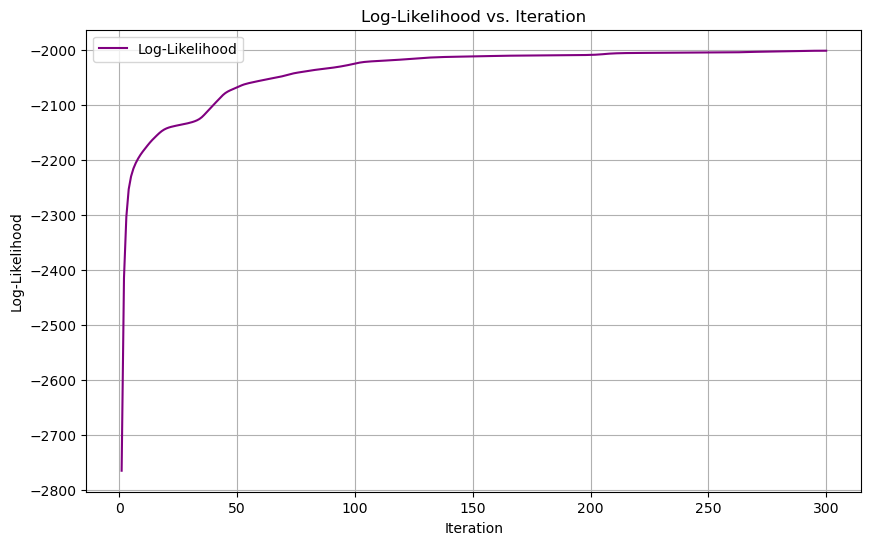

In [28]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, MAX_ITERATIONS + 1), log_likelihoods, color='purple', label='Log-Likelihood')
plt.title('Log-Likelihood vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.legend()
plt.show()